In [1]:
using Plots, LaTeXStrings
default(markersize=3, linewidth=1.5)
using Images, TestImages
using MatrixDepot, JLD
using LinearAlgebra
using SparseArrays, IncompleteLU, Arpack
using IterativeSolvers, LinearMaps, Preconditioners
#include("FNC.jl");
include("functions/chapter02.jl")
include("functions/chapter08.jl")

include group.jl for user defined matrix generators
verify download of index files...
used remote site is https://sparse.tamu.edu/?per_page=All
populating internal database...


sprandsym (generic function with 2 methods)

# Example 8.1.1

Here we load the adjacency matrix of a graph with 2790 nodes. Each node is a web page referring to Roswell, NM, and the edges represent links between web pages.

In [2]:
vars = load("roswelladj.jld")       # get from the book's website

Dict{String,Any} with 2 entries:
  "j" => Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2784, 2784, 2784, 2785, 2785, 2…
  "i" => Int32[149, 179, 180, 181, 182, 183, 184, 185, 186, 187  …  164, 2781, …

In [3]:
i, j = vars["i"], vars["j"]
n = maximum([i; j])

2790

In [4]:
A = sparse(i,j,ones(size(i)),n,n)

2790×2790 SparseMatrixCSC{Float64,Int32} with 8487 stored entries:
  [149 ,    1]  =  1.0
  [179 ,    1]  =  1.0
  [180 ,    1]  =  1.0
  [181 ,    1]  =  1.0
  [182 ,    1]  =  1.0
  [183 ,    1]  =  1.0
  [184 ,    1]  =  1.0
  [185 ,    1]  =  1.0
  [186 ,    1]  =  1.0
  [187 ,    1]  =  1.0
  [188 ,    1]  =  1.0
  [189 ,    1]  =  1.0
  ⋮
  [1031, 2781]  =  1.0
  [164 , 2782]  =  1.0
  [2781, 2783]  =  1.0
  [164 , 2784]  =  1.0
  [2781, 2784]  =  1.0
  [2787, 2784]  =  1.0
  [164 , 2785]  =  1.0
  [2781, 2785]  =  1.0
  [2787, 2785]  =  1.0
  [164 , 2786]  =  1.0
  [165 , 2789]  =  1.0
  [2788, 2789]  =  1.0
  [2790, 2789]  =  1.0

We may define the density of $\mathbf{A}$ as the number of nonzeros divided by the total number of entries.

In [5]:
nnz(A)

8487

In [6]:
n^2

7784100

In [7]:
density = nnz(A) / n^2

0.0010902994565845762

We can compare the storage space needed for the sparse $\mathbf{A}$ with the space needed for its dense or full counterpart. This ratio can never be as small as the density of nonzeros, because of the need to store locations as well as data. However, it's still quite small here, even though the matrix is not really large.

In [8]:
F = Matrix(A)

2790×2790 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  

In [9]:
varinfo(r"A")                       # to see memory consumption

| name |        size | summary                                  |
|:---- | -----------:|:---------------------------------------- |
| A    | 110.516 KiB | 2790×2790 SparseMatrixCSC{Float64,Int32} |


In [10]:
varinfo(r"F")

| name |       size | summary                    |
|:---- | ----------:|:-------------------------- |
| F    | 59.388 MiB | 2790×2790 Array{Float64,2} |


In [11]:
storageratio = 111e3/59e6

0.00188135593220339

Matrix-vector products are also much faster using the sparse form, because operations with structural zeros are skipped.

In [12]:
x = randn(n)
b = A*x
@elapsed for i = 1:200; A*x; end

0.003522097

In [13]:
b = F*x
@elapsed for i = 1:200; F*x; end

0.899328695

However, the sparse storage format is column-oriented. Operations on rows may take a lot longer than similar ones on columns. (Note: Such behavior is dramatic here for MATLAB, but not Julia.)

In [14]:
v = A[:,1000]

r = v'

1×2790 Adjoint{Float64,SparseVector{Float64,Int32}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [15]:
println("time for replacing columns:")
for i = 1:n; A[:,i]=v; end     # run once to improve timing accuracy
@elapsed for i = 1:n; A[:,i]=v; end

time for replacing columns:


0.368604951

In [16]:
println("time for replacing rows:")
for i = 1:n; A[i,:]=r; end     # run once to improve timing accuracy
@elapsed for i = 1:n; A[i,:]=r; end

time for replacing rows:


0.467880331

# Example 8.1.2

Here is the adjacency matrix of a graph representing a "small world" network featuring connections to neighbors and a small number of strangers. 

In [17]:
A = matrixdepot("smallworld",100,4,0.2)

100×100 SparseMatrixCSC{Float64,Int64} with 820 stored entries:
  [2  ,   1]  =  1.0
  [3  ,   1]  =  1.0
  [4  ,   1]  =  1.0
  [5  ,   1]  =  1.0
  [87 ,   1]  =  1.0
  [97 ,   1]  =  1.0
  [98 ,   1]  =  1.0
  [99 ,   1]  =  1.0
  [100,   1]  =  1.0
  [1  ,   2]  =  1.0
  [3  ,   2]  =  1.0
  [4  ,   2]  =  1.0
  ⋮
  [96 ,  99]  =  1.0
  [97 ,  99]  =  1.0
  [98 ,  99]  =  1.0
  [100,  99]  =  1.0
  [1  , 100]  =  1.0
  [2  , 100]  =  1.0
  [3  , 100]  =  1.0
  [4  , 100]  =  1.0
  [91 , 100]  =  1.0
  [96 , 100]  =  1.0
  [97 , 100]  =  1.0
  [98 , 100]  =  1.0
  [99 , 100]  =  1.0

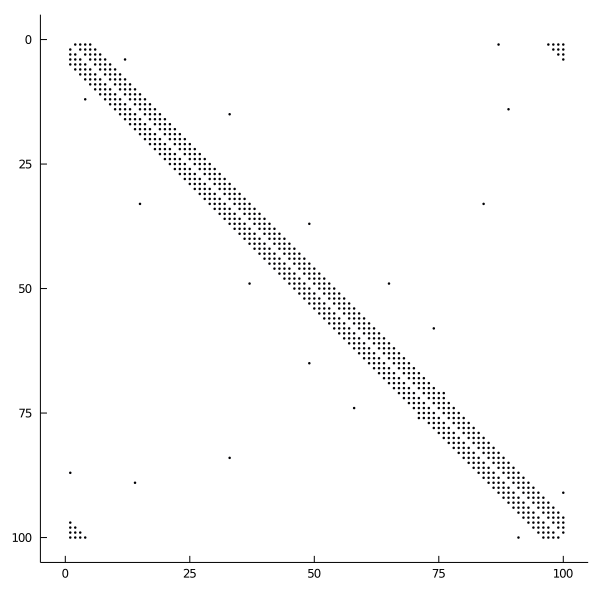

In [18]:
spy(A,color=:black,size=(600,600),m=1.5,colorbar=false)
xlims!(-5,105); ylims!(-5,105)

The number of vertex pairs connected by a path of length $k>1$ grows with $k$, as can be seen here for $k=4$. (This would be "four degrees of separation."

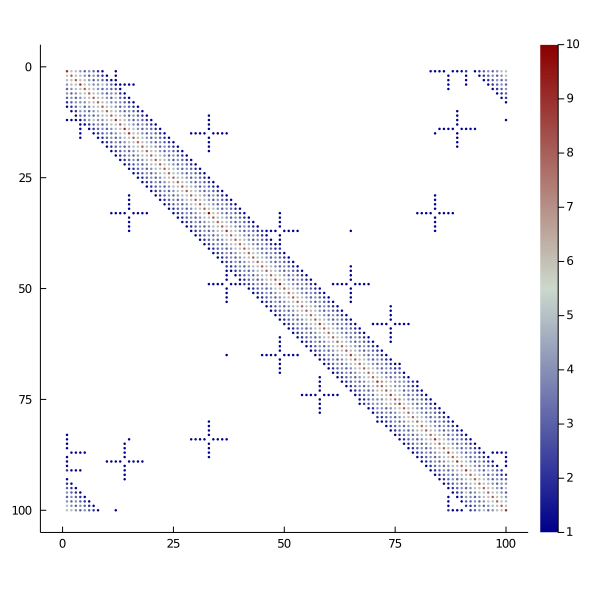

In [19]:
spy(A^2,color=:bluesreds,size=(600,600),m=1.5)
xlims!(-5,105); ylims!(-5,105)

# Example 8.1.3

Here is a matrix with both lower and upper bandwidth equal to one. Such a matrix is called *tridiagonal*. The `spdiagm` command creates a sparse matrix given its diagonal elements. The main or central diagonal is numbered zero, above and to the right of that is positive, and below and to the left is negative.

In [20]:
n = 50;
A = spdiagm(-3=>fill(n,n-3),0=>ones(n),1=>-(1:n-1))

50×50 SparseMatrixCSC{Float64,Int64} with 146 stored entries:
  [1 ,  1]  =  1.0
  [4 ,  1]  =  50.0
  [1 ,  2]  =  -1.0
  [2 ,  2]  =  1.0
  [5 ,  2]  =  50.0
  [2 ,  3]  =  -2.0
  [3 ,  3]  =  1.0
  [6 ,  3]  =  50.0
  [3 ,  4]  =  -3.0
  [4 ,  4]  =  1.0
  [7 ,  4]  =  50.0
  [4 ,  5]  =  -4.0
  ⋮
  [48, 45]  =  50.0
  [45, 46]  =  -45.0
  [46, 46]  =  1.0
  [49, 46]  =  50.0
  [46, 47]  =  -46.0
  [47, 47]  =  1.0
  [50, 47]  =  50.0
  [47, 48]  =  -47.0
  [48, 48]  =  1.0
  [48, 49]  =  -48.0
  [49, 49]  =  1.0
  [49, 50]  =  -49.0
  [50, 50]  =  1.0

In [21]:
Matrix( A[1:7,1:7] )

7×7 Array{Float64,2}:
  1.0  -1.0   0.0   0.0   0.0   0.0   0.0
  0.0   1.0  -2.0   0.0   0.0   0.0   0.0
  0.0   0.0   1.0  -3.0   0.0   0.0   0.0
 50.0   0.0   0.0   1.0  -4.0   0.0   0.0
  0.0  50.0   0.0   0.0   1.0  -5.0   0.0
  0.0   0.0  50.0   0.0   0.0   1.0  -6.0
  0.0   0.0   0.0  50.0   0.0   0.0   1.0

Without pivoting, the LU factors have the same lower and upper bandwidth as the orignal matrix. 

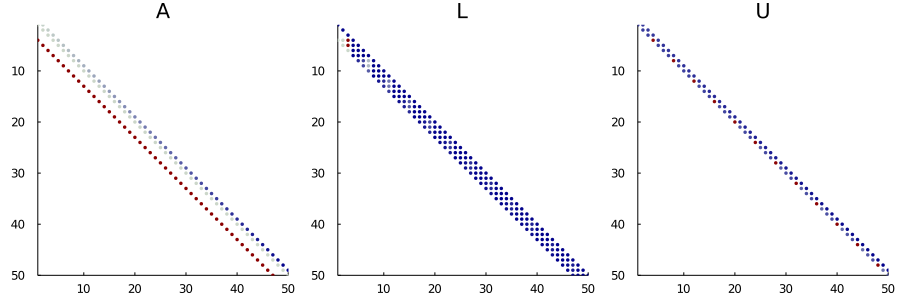

In [22]:
L,U = lufact(A)
spy(A,layout=(1,3),subplot=1,markersize=2,title="A",color=:bluesreds,colorbar=false,size=(900,300))
spy!(sparse(L),subplot=2,markersize=2,title="L",color=:bluesreds,colorbar=false)
spy!(sparse(U),subplot=3,markersize=2,title="U",color=:bluesreds,colorbar=false)

However, if we introduce row pivoting, bandedness may be expanded or destroyed.

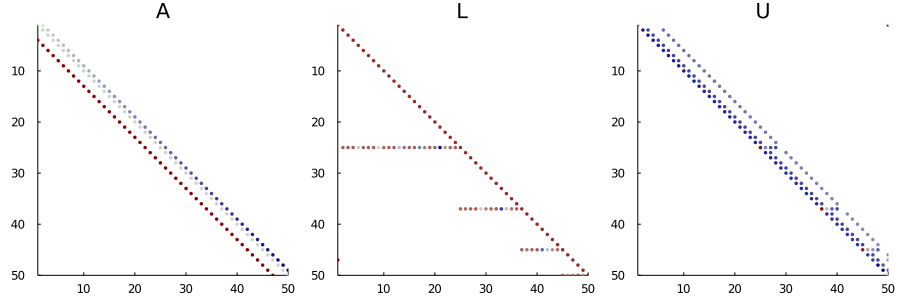

In [23]:
fact = lu(A)
spy(A,layout=(1,3),subplot=1,markersize=2,title="A",color=:bluesreds,colorbar=false,size=(900,300))
spy!(sparse(fact.L),subplot=2,markersize=2,title="L",color=:bluesreds,colorbar=false)
spy!(sparse(fact.U),subplot=3,markersize=2,title="U",color=:bluesreds,colorbar=false)

# Example 8.1.4

The following generates a random sparse matrix with prescribed eigenvalues.

In [24]:
n = 1000
density = 1.23e-3
lambda = @. 1/(1:n)
A = sprandsym(n,density,lambda);

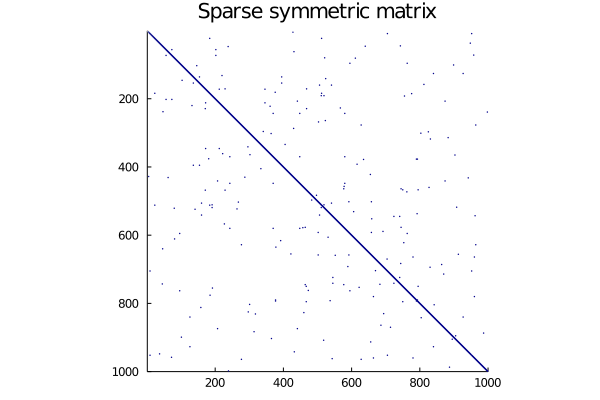

In [25]:
spy(A,title="Sparse symmetric matrix",color=:bluesreds,colorbar=false)

In [26]:
lambda,V = eigs(A,nev=5,which=:LM)    # largest magnitude
lambda

5-element Array{Complex{Float64},1}:
  0.9999999999999994 + 0.0im
  0.5000000000000009 + 0.0im
 0.33333333333333337 + 0.0im
 0.24999999999999967 + 0.0im
  0.1999999999999993 + 0.0im

In [27]:
lambda,V = eigs(A,nev=5,sigma=0)    # closest to zero
1 ./ lambda

5-element Array{Complex{Float64},1}:
 999.9999999999959 - 0.0im
 998.9999999999937 - 0.0im
 997.9999999999906 - 0.0im
  996.999999999988 - 0.0im
  995.999999999998 - 0.0im

The scaling of time to solve a sparse linear system is not easy to predict unless you have some more information about the matrix (such as bandedness). But it will typically be a great deal faster than the dense or full matrix case.

In [28]:
x = @. 1/(1:n);  b = A*x;
@time sparse_err = norm(x - A\b)
@time sparse_err = norm(x - A\b)

  1.142774 seconds (2.54 M allocations: 125.453 MiB, 3.95% gc time)
  0.000280 seconds (69 allocations: 613.984 KiB)


2.0688998012370751e-16

In [29]:
A = Matrix(A)  # convert to regular matrix
x = @. 1/(1:n);  b = A*x;
@time dense_err = norm(x - A\b)
@time dense_err = norm(x - A\b)

  1.062874 seconds (2.49 M allocations: 129.685 MiB, 2.46% gc time)
  0.020286 seconds (6 allocations: 7.653 MiB)


4.562556684388694e-16

In [30]:
0.108273/0.000476

227.4642857142857

In [31]:
sparse_err, dense_err

(2.0688998012370751e-16, 4.562556684388694e-16)

# Example 8.2.1

Here we let $\mathbf{A}$ be a $5\times 5$ matrix. We also choose a random 5-vector.

In [32]:
A = rand(1.:9.,5,5)

5×5 Array{Float64,2}:
 3.0  1.0  1.0  2.0  3.0
 6.0  5.0  5.0  9.0  1.0
 4.0  5.0  9.0  4.0  6.0
 5.0  7.0  7.0  2.0  4.0
 1.0  1.0  4.0  5.0  4.0

In [33]:
sum(A,dims=1)

1×5 Array{Float64,2}:
 19.0  19.0  26.0  22.0  18.0

In [34]:
A = A./sum(A,dims=1)

5×5 Array{Float64,2}:
 0.157895   0.0526316  0.0384615  0.0909091  0.166667
 0.315789   0.263158   0.192308   0.409091   0.0555556
 0.210526   0.263158   0.346154   0.181818   0.333333
 0.263158   0.368421   0.269231   0.0909091  0.222222
 0.0526316  0.0526316  0.153846   0.227273   0.222222

In [35]:
sum(A,dims=1)

1×5 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0

In [36]:
eigen(A)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -0.24693708366856137 + 0.0im
  0.10210526607692294 - 0.01613879984625389im
  0.10210526607692294 + 0.01613879984625389im
  0.12306434237882193 + 0.0im
   1.0000000000000013 + 0.0im
vectors:
5×5 Array{Complex{Float64},2}:
 -0.0469613+0.0im  …  -0.418791+0.0im  -0.176143+0.0im
   0.617644+0.0im      0.738163+0.0im  -0.532391+0.0im
  -0.243446+0.0im      -0.39379+0.0im  -0.571735+0.0im
  -0.665367+0.0im       0.28408+0.0im  -0.512005+0.0im
    0.33813+0.0im     -0.209662+0.0im  -0.310648+0.0im

In [37]:
x = randn(5)

5-element Array{Float64,1}:
 -0.43163331950205
  0.08298968242777954
  0.452780609570552
 -1.9042557783019973
  0.5142029108956764

Applying matrix-vector multiplication once doesn't do anything recognizable.

In [38]:
y = A*x

5-element Array{Float64,1}:
 -0.13378378905744773
 -0.7778395736334521
 -0.08712638597652139
 -0.019956945824820327
 -0.26720920041779794

Repeating the multiplication still doesn't do anything obvious.

In [39]:
z = A*y

5-element Array{Float64,1}:
 -0.11176283047884872
 -0.2867063718894874
 -0.3557170355473722
 -0.4064299288088891
 -0.12529972818544205

But if we keep repeating the matrix-vector multiplication, something remarkable happens: $\mathbf{A}\mathbf{x}\approx \mathbf{x}$. 

In [40]:
for j = 1:8;  x = A*x;  end
[x A*x]

5×2 Array{Float64,2}:
 -0.107711  -0.107709
 -0.325535  -0.325556
 -0.349617  -0.349609
 -0.313105  -0.313081
 -0.189949  -0.189961

In [41]:
norm(x - A*x)

3.4503763484783646e-5

This seems to occur regardless of the starting value of $x$. 

In [42]:
x = randn(5)
for j = 1:10;  x = A*x;  end   # computing A^10*x
[x A*x]

5×2 Array{Float64,2}:
 0.0285237  0.0285237
 0.086212   0.0862127
 0.092584   0.0925837
 0.082912   0.0829112
 0.0503044  0.0503048

In [43]:
norm(x - A*x)

1.0838992210548392e-6

# Example 8.2.2

We set up a $5\times 5$ matrix with prescribed eigenvalues, then apply the power iteration.

In [44]:
lambda = [1,-0.75,0.6,-0.4,0]
A = triu(ones(5,5),1) + diagm(lambda)   # triangular matrix, eigs on diagonal

5×5 Array{Float64,2}:
 1.0   1.0   1.0   1.0  1.0
 0.0  -0.75  1.0   1.0  1.0
 0.0   0.0   0.6   1.0  1.0
 0.0   0.0   0.0  -0.4  1.0
 0.0   0.0   0.0   0.0  0.0

We run the power iteration 60 times. The best estimate of the dominant eigenvalue is the last entry of `gamma`. 

In [45]:
gamma,x = poweriter(A,60)
gamma

60-element Array{Float64,1}:
 5.277161208103404
 1.9140252030617937
 0.9450979730130672
 1.2360905306908334
 0.9502021168624866
 1.0983145330742852
 0.9651004950961515
 1.047162164364284
 0.9777044937863244
 1.0241498921489627
 0.98644314366245
 1.0128184993214013
 0.9919954052573694
 ⋮
 0.9999997236649263
 1.0000002072605993
 0.9999998445601248
 1.00000011658325
 0.9999999125645679
 1.0000000655777768
 0.9999999508173889
 1.0000000368873911
 0.9999999723347162
 1.0000000207491184
 0.9999999844382546
 1.0000000116713652

In [46]:
eigval = gamma[end]

1.0000000116713652

We check linear convergence using a log-linear plot of the error. We use our best estimate in order to compute the error at each step.

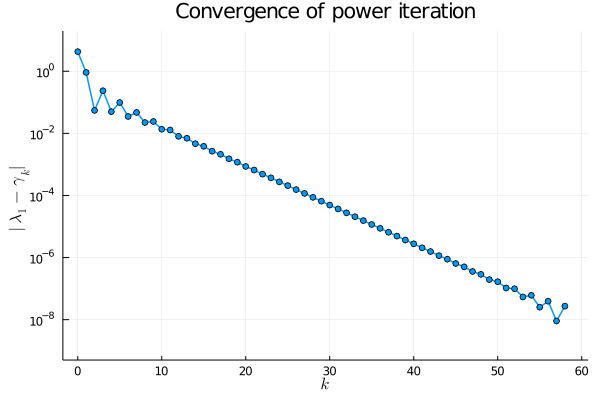

In [47]:
err = eigval .- gamma
plot(0:59,abs.(err),m=:o,label="", 
    title="Convergence of power iteration",
    xlabel=L"k",yaxis=(L"|\lambda_1 - \gamma_k|",:log10,[1e-9,1e1]) )

The trend is clearly a straight line asymptotically. We can get a refined estimate of the error reduction in each step by using the exact eigenvalues.

In [48]:
@show theory = lambda[2]/lambda[1];
@show observed = err[40]/err[39];

theory = lambda[2] / lambda[1] = -0.75
observed = err[40] / err[39] = -0.7461609844669668


Note that the error is supposed to change sign on each iteration. An effect of these alternating signs is that estimates oscillate around the exact value.

In [49]:
gamma[36:40]

5-element Array{Float64,1}:
 1.0000116372094177
 0.9999912792666348
 1.0000065448503783
 0.999995093940315
 1.000003681090407

In [50]:
lambar = (gamma[60]+gamma[59])/2

0.9999999980548099

# Example 8.3.1

We set up a $5\times 5$ triangular matrix with prescribed eigenvalues on its diagonal.

In [51]:
lambda = [1,-0.75,0.6,-0.4,0]
A = triu(ones(5,5),1) + diagm(lambda)   # triangular matrix, eigs on diagonal

5×5 Array{Float64,2}:
 1.0   1.0   1.0   1.0  1.0
 0.0  -0.75  1.0   1.0  1.0
 0.0   0.0   0.6   1.0  1.0
 0.0   0.0   0.0  -0.4  1.0
 0.0   0.0   0.0   0.0  0.0

We run inverse iteration with the shift $s=0.7$ and take the final estimate as our ``exact'' answer to observe the convergence. 

In [52]:
gamma,x = inviter(A,0.7,30)
gamma

30-element Array{Float64,1}:
 0.618568685653405
 0.6128242871442845
 0.5971841985034927
 0.6010768531687669
 0.5996559026466705
 0.600116504503549
 0.5999614026749924
 0.6000128984850548
 0.5999957051134258
 0.6000014322850004
 0.5999995226654953
 0.6000001591249396
 0.5999999469602786
 ⋮
 0.5999999999272424
 0.6000000000242525
 0.5999999999919158
 0.6000000000026947
 0.5999999999991017
 0.6000000000002994
 0.5999999999999002
 0.6000000000000333
 0.5999999999999889
 0.6000000000000036
 0.5999999999999988
 0.6000000000000004

In [53]:
eigval = gamma[end]

0.6000000000000004

As expected, the eigenvalue that was found is the one closest to $0.7$. The convergence is again linear.

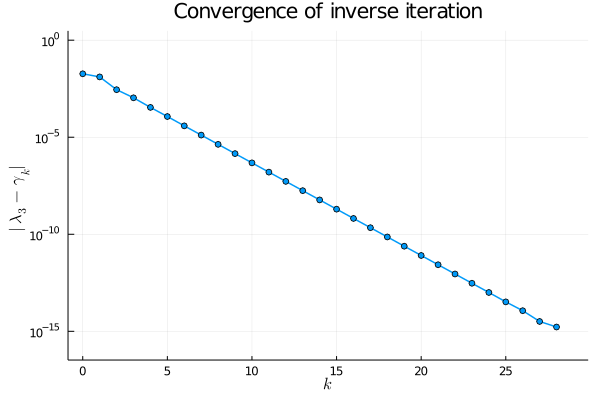

In [54]:
err = eigval .- gamma
plot(0:29,abs.(err),m=:o,label="", 
    title="Convergence of inverse iteration",
    xlabel=L"k",yaxis=(L"|\lambda_3 - \gamma_k|",:log10,[1e-16,1]) )

The observed linear convergence rate is found from the data. 

In [55]:
observed_rate = err[22]/err[21]

-0.3332600933809393

In the numbering of this example, the eigenvalue closest to $s=0.7$ is $\lambda_3$ and the next-closest is $\lambda_1$.

In [56]:
lambda

5-element Array{Float64,1}:
  1.0
 -0.75
  0.6
 -0.4
  0.0

In [57]:
lambda .- 0.7

5-element Array{Float64,1}:
  0.30000000000000004
 -1.45
 -0.09999999999999998
 -1.1
 -0.7

In [58]:
theoretical_rate = (lambda[3]-0.7) / (lambda[1]-0.7)

-0.3333333333333332

# Example 8.3.2

In [59]:
lambda = [1,-0.75,0.6,-0.4,0]
A = triu(ones(5,5),1) + diagm(lambda)   # triangular matrix, eigs on diagonal

5×5 Array{Float64,2}:
 1.0   1.0   1.0   1.0  1.0
 0.0  -0.75  1.0   1.0  1.0
 0.0   0.0   0.6   1.0  1.0
 0.0   0.0   0.0  -0.4  1.0
 0.0   0.0   0.0   0.0  0.0

We begin with a shift $s=0.7$, which is closest to the eigenvalue 0.6.

In [60]:
s = 0.7
x = ones(5)
y = (A-s*I)\x
gamma = x[1]/y[1] + s

0.7034813925570228

Note that the result is not yet any closer to the targeted $0.6$. But we proceed (without being too picky about normalization here).

In [61]:
s = gamma
x = y/y[1]
y = (A-s*I)\x
gamma = x[1]/y[1] + s

0.5612761406172997

Still not much apparent progress. However, in just a few more iterations the results are dramatically better.

In [62]:
for k = 1:4
    s = gamma  
    x = y/y[1]
    y = (A-s*I)\x  
    gamma = x[1]/y[1] + s
    @show gamma
end

gamma = 0.5964312884753865
gamma = 0.5999717091820104
gamma = 0.5999999978556353
gamma = 0.6


# Example 8.4.1

First we define a triangular matrix with known eigenvalues and a random vector $b$.

In [63]:
lambda = @. 10 + (1:100)
A = triu(rand(100,100),1) + diagm(lambda)
b = rand(100);
A

100×100 Array{Float64,2}:
 11.0   0.0315026   0.513993    0.23575   …    0.2187       0.830653
  0.0  12.0         0.0822385   0.441217       0.0678829    0.301189
  0.0   0.0        13.0         0.770279       0.562444     0.479683
  0.0   0.0         0.0        14.0            0.197936     0.0213882
  0.0   0.0         0.0         0.0            0.526965     0.351795
  0.0   0.0         0.0         0.0       …    0.558799     0.209329
  0.0   0.0         0.0         0.0            0.283621     0.0963104
  0.0   0.0         0.0         0.0            0.489409     0.715208
  0.0   0.0         0.0         0.0            0.362045     0.00152131
  0.0   0.0         0.0         0.0            0.131158     0.0666191
  0.0   0.0         0.0         0.0       …    0.624464     0.10818
  0.0   0.0         0.0         0.0            0.158904     0.739895
  0.0   0.0         0.0         0.0            0.390806     0.853136
  ⋮                                       ⋱               
  0.0   0.0   

Next we build up the first ten Krylov matrices iteratively, using renormalization after each matrix-vector multiplication. 

In [64]:
Km = [b/norm(b) zeros(100,29)]
for m = 1:29      
    v = A*Km[:,m]
    Km[:,m+1] = v/norm(v)
end
Km

100×30 Array{Float64,2}:
 0.170997   0.0870618  0.0651896  …  0.0408833  0.040682   0.0404912
 0.0709263  0.0665395  0.0585503     0.0388783  0.0386577  0.038448
 0.144447   0.0763803  0.0592606     0.0403876  0.0401908  0.0400045
 0.0865757  0.0706208  0.061952      0.038682   0.0384573  0.038245
 0.0745662  0.0669971  0.0578        0.0365661  0.0363838  0.0362133
 0.161045   0.0845294  0.0627092  …  0.0394527  0.0392465  0.0390524
 0.018191   0.0460199  0.0477969     0.0328903  0.0326888  0.032497
 0.166225   0.0871883  0.0629694     0.0411574  0.0409918  0.0408335
 0.143653   0.0835358  0.0622128     0.0384905  0.0382663  0.0380534
 0.120288   0.0805366  0.062743      0.0368529  0.0366816  0.0365192
 0.155211   0.0914524  0.0679868  …  0.0417806  0.0415335  0.0412989
 0.114008   0.0827072  0.0668118     0.0418456  0.0416135  0.0413927
 0.0434948  0.0657817  0.0661151     0.0426179  0.042413   0.0422191
 ⋮                                ⋱                        
 0.0478991  0.0673053

Now we solve a least squares problem for Krylov matrices of increasing dimension.

In [65]:
resid = zeros(30)
for m = 1:30  
    z = (A*Km[:,1:m])\b  # Solve the least-squares problems
    x = Km[:,1:m]*z
    resid[m] = norm(b-A*x)
end
resid

30-element Array{Float64,1}:
 1.6116024415292503
 0.7658115004849486
 0.381589695998046
 0.19488780487003896
 0.0994751124497715
 0.05209263188879688
 0.02792752629466851
 0.015304620990100673
 0.00756325063202836
 0.0036080748224808362
 0.0020197426474209794
 0.001090171293164517
 0.0005611754550439042
 ⋮
 2.703429137585322e-5
 1.2091845329720341e-5
 1.579677393931386e-5
 2.028981876648566e-5
 2.5628294045939046e-5
 1.1187258869530981e-5
 1.3997703479806129e-5
 1.740583093627024e-5
 2.1435090864499763e-5
 9.947443247573709e-6
 1.1881764008951781e-5
 1.4138999582043906e-5

The linear system approximations show smooth linear convergence at first, but the convergence stagnates after only a few digits have been found.

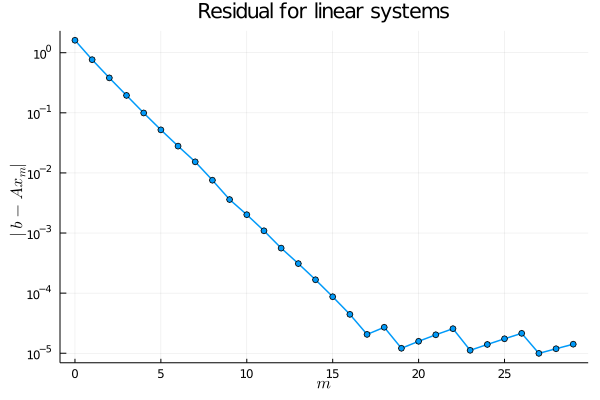

In [66]:
plot(0:29,resid,m=:o,
    xaxis=(L"m"),yaxis=(:log10,L"\| b-Ax_m \|"), 
    title="Residual for linear systems",leg=:none)

# Example 8.4.2

We illustrate a few steps of the Arnoldi iteration for a small matrix.

In [67]:
A = rand(1.:9.,6,6)

6×6 Array{Float64,2}:
 4.0  6.0  9.0  5.0  3.0  6.0
 1.0  6.0  8.0  8.0  2.0  2.0
 4.0  5.0  8.0  8.0  6.0  6.0
 6.0  1.0  7.0  3.0  9.0  2.0
 4.0  6.0  2.0  6.0  3.0  7.0
 8.0  3.0  3.0  4.0  5.0  9.0

The seed vector determines the first member of the orthonormal basis.

In [68]:
u = randn(6)
Q = u/norm(u)

6-element Array{Float64,1}:
  0.5998251343664232
 -0.34274517166666735
 -0.34247453068046085
 -0.181885895433652
  0.28566232933060953
 -0.5392228722526484

Multiplication by $\mathbf{A}$ gives us a new vector in $\mathcal{K}_2$. 

In [69]:
Aq = A*Q[:,1]

6-element Array{Float64,1}:
 -6.027220991350781
 -6.158650390390562
 -5.030671987312781
  1.8057414529378784
 -4.351008044273856
 -1.409295817465396

We subtract off its projection in the previous direction. The remainder is rescaled to give us the next orthonormal column.

In [70]:
v = Aq - dot(Q[:,1],Aq)*Q[:,1]
Q = [Q v/norm(v)]

6×2 Array{Float64,2}:
  0.599825  -0.510575
 -0.342745  -0.572724
 -0.342475  -0.471165
 -0.181886   0.152851
  0.285662  -0.376446
 -0.539223  -0.155656

On the next pass, we have to subtract off the projections in two previous directions.

In [71]:
Aq = A*Q[:,2]
v = Aq - dot(Q[:,1],Aq)*Q[:,1] - dot(Q[:,2],Aq)*Q[:,2]
Q = [Q v/norm(v)]

6×3 Array{Float64,2}:
  0.599825  -0.510575  -0.319623
 -0.342745  -0.572724   0.291449
 -0.342475  -0.471165  -0.0447973
 -0.181886   0.152851  -0.827678
  0.285662  -0.376446  -0.158724
 -0.539223  -0.155656  -0.317248

At every step, $Q_m$ is an ONC matrix.

In [72]:
opnorm( Q'*Q - I )

5.8942861904093895e-16

And $Q_m$ spans the same space as the 3-dimensional Krylov matrix.

In [73]:
K = [ u A*u A*A*u ];
[Q K]

6×6 Array{Float64,2}:
  0.599825  -0.510575  -0.319623    1.28682   -12.9304   -254.902
 -0.342745  -0.572724   0.291449   -0.735302  -13.2124   -172.268
 -0.342475  -0.471165  -0.0447973  -0.734722  -10.7925   -247.278
 -0.181886   0.152851  -0.827678   -0.390206    3.87392  -244.776
  0.285662  -0.376446  -0.158724    0.612841   -9.33436  -178.504
 -0.539223  -0.155656  -0.317248   -1.15681    -3.02341  -233.844

In [74]:
@show rank( [Q K] )

rank([Q K]) = 3


3

In [75]:
C = Q\K

3×3 Array{Float64,2}:
  2.14533      -1.27215      110.458
 -8.62817e-32  23.8306       411.5
 -2.22045e-16  -8.88178e-16  347.458

In [76]:
Q*C - K

6×3 Array{Float64,2}:
  2.22045e-16  -1.77636e-15   8.52651e-14
 -3.33067e-16  -1.77636e-15  -2.84217e-14
 -2.22045e-16   0.0           0.0
  1.11022e-16   8.88178e-16  -2.84217e-14
  2.22045e-16  -1.77636e-15   2.84217e-14
 -2.22045e-16  -4.44089e-16   0.0

# Example 8.5.1

We define a triangular matrix with known eigenvalues and a random vector $b$.

In [77]:
lambda = @. 10 + (1:100)
A = triu(rand(100,100),1) + diagm(lambda)
b = rand(100);

Instead of building up the Krylov matrices, we use the Arnoldi iteration to generate equivalent orthonormal vectors. 

In [78]:
Q,H = arnoldi(A,b,60);

In [79]:
H

61×60 Array{Float64,2}:
 81.3796  35.2568   9.32869  -1.51863   1.98204  …  -0.909831    -0.182696
 20.3298  51.2098  27.9778    2.01658   0.72911     -0.570712    -0.85011
  0.0     23.0991  55.7239   26.8952    1.18248      0.164367    -0.853466
  0.0      0.0     24.3163   65.9245   25.1223      -0.964696     0.561835
  0.0      0.0      0.0      23.9282   56.5339       0.124777     0.473537
  0.0      0.0      0.0       0.0      24.7832   …   0.416105    -0.660178
  0.0      0.0      0.0       0.0       0.0         -0.00340672   0.507765
  0.0      0.0      0.0       0.0       0.0         -0.152115    -0.708962
  0.0      0.0      0.0       0.0       0.0         -0.15961     -0.250929
  0.0      0.0      0.0       0.0       0.0          0.209125     0.412544
  0.0      0.0      0.0       0.0       0.0      …   0.695337    -0.491079
  0.0      0.0      0.0       0.0       0.0         -0.132901    -0.452984
  0.0      0.0      0.0       0.0       0.0          0.325588     0.128793
  

In [80]:
Q'Q

61×61 Array{Float64,2}:
  1.0          -1.14748e-16   2.09613e-16  …  -0.000508077   0.000190907
 -1.14748e-16   1.0          -2.08037e-16      0.000515394  -0.000193656
  2.09613e-16  -2.08037e-16   1.0              0.000469386  -0.000176369
 -4.2018e-16    2.93656e-16   4.07703e-16     -0.000258764   9.72291e-5
  6.43463e-16  -7.70581e-16  -7.73953e-16     -0.000127586   4.79397e-5
 -1.19305e-15   1.34837e-15   1.27538e-15  …  -2.6879e-5     1.00996e-5
  2.55728e-15  -2.73194e-15  -2.41755e-15     -1.99391e-5    7.49199e-6
 -5.00356e-15   5.15919e-15   4.57217e-15     -7.86507e-7    2.95525e-7
  8.9395e-15   -9.15061e-15  -8.19224e-15      7.28449e-6   -2.73711e-6
 -1.56521e-14   1.59841e-14   1.44609e-14     -1.4333e-5     5.38555e-6
  3.10949e-14  -3.16646e-14  -2.87053e-14  …  -4.51571e-6    1.69675e-6
 -5.74862e-14   5.84125e-14   5.30831e-14     -1.86143e-6    6.99421e-7
  8.82509e-14  -8.95346e-14  -8.14904e-14      1.37467e-6   -5.16524e-7
  ⋮                                  

In [81]:
orthogres = [norm(Q[:,1:m]'Q[:,1:m] - I) for m = 1:61]

61-element Array{Float64,1}:
 4.440892098500626e-16
 5.223536737416693e-16
 8.691580984157279e-16
 1.275058584015453e-15
 2.300674437492065e-15
 4.068103954279666e-15
 7.83100502353326e-15
 1.4925163303777753e-14
 2.711150793667747e-14
 4.80995453649518e-14
 9.235759337751634e-14
 1.7251051854692457e-13
 2.823917496052128e-13
 ⋮
 0.3246628609578617
 0.6241828781211318
 1.1068684397462856
 1.3447287413839444
 1.4037850282588384
 1.4120873826885683
 1.413946037839223
 1.4141736130237588
 1.4142082837148282
 1.4142128814616786
 1.4142134674680436
 1.4142135502025006

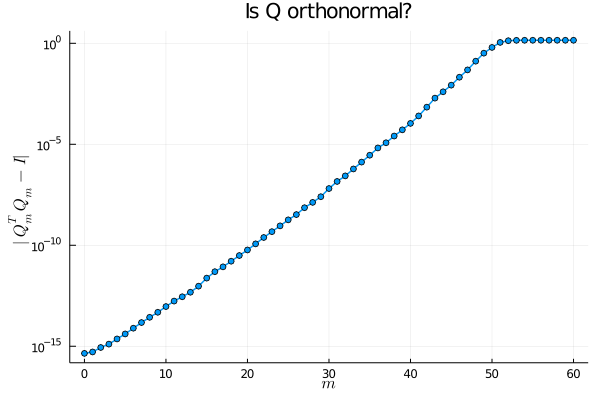

In [82]:
plot(0:60, orthogres, m=:o,
    xaxis=(L"m"),yaxis=(:log10,L"\| Q_m^TQ_m - I \|"), 
    title="Is Q orthonormal?",leg=:none)

In [83]:
condQ = [cond(Q[:,1:m]) for m = 1:61]

61-element Array{Float64,1}:
     1.0
     1.0
     1.0
     1.0000000000000004
     1.000000000000001
     1.0000000000000009
     1.0000000000000007
     1.0000000000000007
     1.0000000000000002
     1.0000000000000282
     1.000000000000065
     1.0000000000001221
     1.0000000000001996
     ⋮
     1.2633120459378078
     1.6062840482799352
     2.8640482043439057
     6.301244591869467
    16.438370047162344
    36.459375019023895
   102.81823610338294
   266.08143529715886
   731.9987135465248
  2038.1077302150595
  5459.185127204488
 15244.619115876167

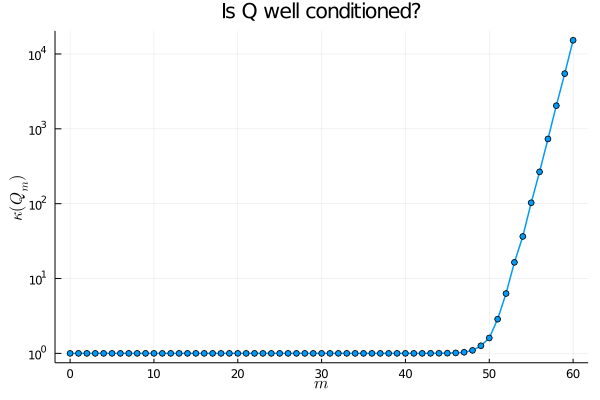

In [84]:
plot(0:60, condQ, m=:o,
    xaxis=(L"m"),yaxis=(:log10,L"\kappa(Q_m)"), 
    title="Is Q well conditioned?",leg=:none)

The Arnoldi bases are used to solve the least squares problems defining the GMRES iterates. 

In [85]:
resid = [norm(b);zeros(60)]
for m = 1:60  
    s = [norm(b); zeros(m)]
    z = H[1:m+1,1:m]\s
    x = Q[:,1:m]*z
    resid[m+1] = norm(b-A*x)
 end

The approximations converge smoothly, practically all the way to machine epsilon.

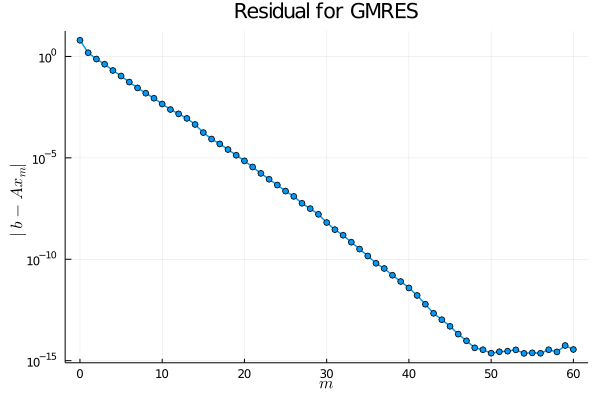

In [86]:
plot(0:60,resid,m=:o,
    xaxis=(L"m"),yaxis=(:log10,L"\| b-Ax_m \|"), 
    title="Residual for GMRES",leg=:none)

In [87]:
resid[end]

3.55506426465173e-15

# Example 8.5.2

The following experiments are based on a matrix resulting from discretization of a partial differential equation.

In [88]:
d = 50;
A = d^2*matrixdepot("poisson",d)
n = size(A,1)

2500

We compare unrestarted GMRES with three different thresholds for restarting.

### IterativeSolvers.jl

For the following test, we are using the `gmres` function from the [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl) package.

In [89]:
methods(gmres)

# 1 method for generic function "gmres":
[1] gmres(A, b; kwargs...) in IterativeSolvers at /Users/krislock/.julia/packages/IterativeSolvers/3g7hG/src/gmres.jl:135

In [90]:
?gmres

search: gmres gmres! arngmres GammaCorrection



```
gmres(A, b; kwargs...) -> x, [history]
```

Same as [`gmres!`](@ref), but allocates a solution vector `x` initialized with zeros.


In [91]:
?gmres!

search: gmres! gmres arngmres



```
gmres!(x, A, b; kwargs...) -> x, [history]
```

Solves the problem $Ax = b$ with restarted GMRES.

# Arguments

  * `x`: Initial guess, will be updated in-place;
  * `A`: linear operator;
  * `b`: right-hand side.

## Keywords

  * `initially_zero::Bool`: If `true` assumes that `iszero(x)` so that one matrix-vector product can be saved when computing the initial residual vector;
  * `tol`: relative tolerance;
  * `restart::Int = min(20, size(A, 2))`: restarts GMRES after specified number of iterations;
  * `maxiter::Int = size(A, 2)`: maximum number of inner iterations of GMRES;
  * `Pl`: left preconditioner;
  * `Pr`: right preconditioner;
  * `log::Bool`: keep track of the residual norm in each iteration;
  * `verbose::Bool`: print convergence information during the iterations.

# Return values

**if `log` is `false`**

  * `x`: approximate solution.

**if `log` is `true`**

  * `x`: approximate solution;
  * `history`: convergence history.


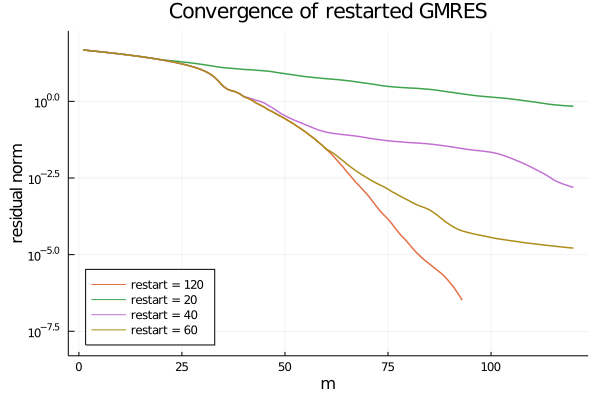

In [92]:
b = ones(n);
maxit = 120;  rtol = 1e-8;
rest = [maxit,20,40,60]
plt = plot([],[],label="",title="Convergence of restarted GMRES",leg=:bottomleft,
    xaxis=("m"), yaxis=(:log10,"residual norm",[1e-8,100]))
for j = 1:4
    x,hist = gmres(A,b,restart=rest[j],tol=rtol,maxiter=maxit,log=true)
    plot!(hist[:resnorm],label="restart = $(rest[j])")
end
display(plt)

The "pure" curve is the lowest one. All of the other curves agree with it until they encounter their first restart. 

# Example 8.6.1

In this example we compare MINRES and CG on some pseudorandom SPD problems.  The first matrix has a condition number of 100. 

In [93]:
n = 2000
density = 0.005
A = sprandsym(n,density,1e-2)
nnz(A)

20056

We cook up a linear system whose solution we happen to know exactly.

In [94]:
x = (1:n)/n
b = A*x;

Now we apply both methods and compare the convergence of the system residuals, using the built-in function `pcg` in the latter case.

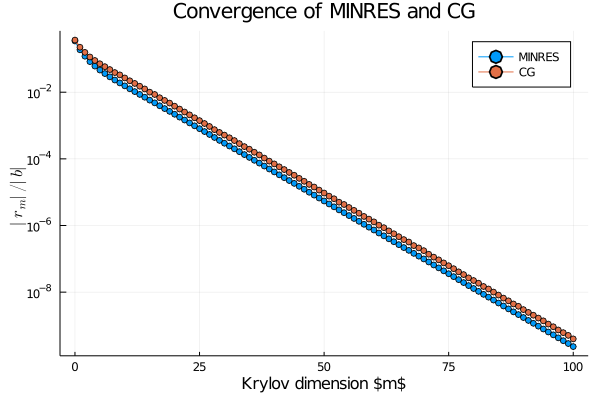

In [95]:
xMR,histMR = minres(A,b,tol=1e-12,maxiter=101,log=true)
xCG,histCG = cg(A,b,tol=1e-12,maxiter=101,log=true)

plot(0:100,[histMR[:resnorm] histCG[:resnorm]]/norm(b),m=:o,label=["MINRES" "CG"], 
    title="Convergence of MINRES and CG",
    xaxis=("Krylov dimension \$m\$"), yaxis=(:log10,L"\|r_m\| / \|b\|") )

There is virtually no difference between the two methods here when measuring the residual. We see little difference in the errors as well. 

In [96]:
@show errorMR = norm( xMR - x ) / norm(x);
@show errorCG = norm( xCG - x) / norm(x);

errorMR = norm(xMR - x) / norm(x) = 3.7091858247996035e-9
errorCG = norm(xCG - x) / norm(x) = 2.3546457676958246e-9


Next we use a system matrix whose condition number is $10^4$. 

In [97]:
A = sprandsym(n,density,1e-4);

Now we find that the CG residual jumps unexpectedly, but overall both methods converge at about the same linear rate. Note from the scales that both methods have actually made very little progress after 100 iterations, though. 

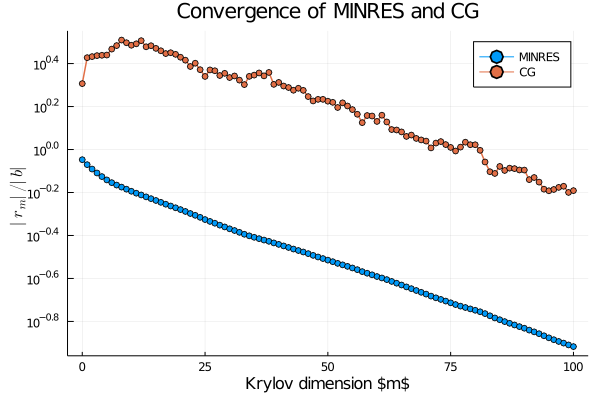

In [98]:
xMR,histMR = minres(A,b,tol=1e-12,maxiter=101,log=true)
xCG,histCG = cg(A,b,tol=1e-12,maxiter=101,log=true)

plot(0:100,[histMR[:resnorm] histCG[:resnorm]]/norm(b),m=:o,label=["MINRES" "CG"], 
    title="Convergence of MINRES and CG",
    xaxis=("Krylov dimension \$m\$"), yaxis=(:log10,L"\|r_m\| / \|b\|") )

The errors confirm that we are nowhere near the correct solution in either case.

In [99]:
@show errorMR = norm( xMR - x ) / norm(x);
@show errorCG = norm( xCG - x) / norm(x);

errorMR = norm(xMR - x) / norm(x) = 618.280963562586
errorCG = norm(xCG - x) / norm(x) = 724.6383670803565


# Example 8.7.1

We use a readily available test image.

(m, n) = size(img) = (512, 512)


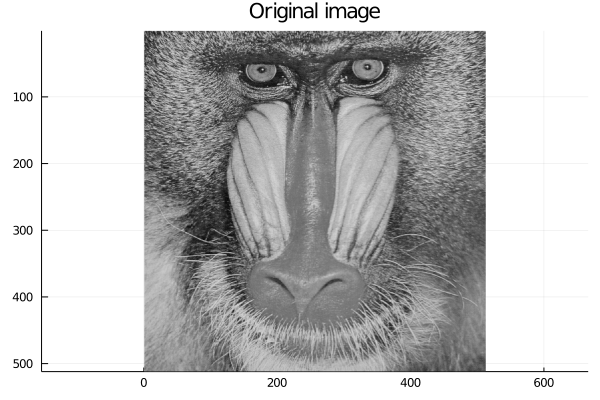

In [100]:
img = testimage("mandrill");
@show m,n = size(img)
plot(Gray.(img),title="Original image",aspect_ratio=1)

We define the one-dimensional tridiagonal blurring matrices.

In [101]:
X = @. Float64(Gray(img))

B = spdiagm(0=>fill(0.5,m),1=>fill(0.25,m-1),-1=>fill(0.25,m-1));
C = spdiagm(0=>fill(0.5,n),1=>fill(0.25,n-1),-1=>fill(0.25,n-1));

Finally, we show the results of using $k=12$ repetitions of the blur in each direction.

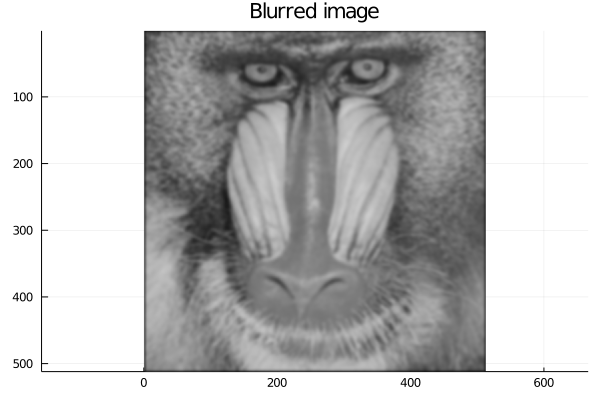

In [102]:
blur = X -> B^12 * X * C^12;
plot(Gray.(blur(X)),title="Blurred image",aspect_ratio=1)

# Example 8.7.2

We repeat the earlier process to blur the original image $X$ to get $Z$. 

In [103]:
img = testimage("mandrill");
m,n = size(img)

X = @. Float64(Gray(img))

B = spdiagm(0=>fill(0.5,m),1=>fill(0.25,m-1),-1=>fill(0.25,m-1));
C = spdiagm(0=>fill(0.5,n),1=>fill(0.25,n-1),-1=>fill(0.25,n-1));
blur = X -> B^12 * X * C^12;
Z = blur(X);

Now we imagine that $X$ is unknown and that the blurred $Z$ is given. We want to invert the blur transformation using the transformation itself. But we have to translate between vectors and images each time. 

In [104]:
unvec = z -> reshape(z,m,n)
T = LinearMap(x -> vec(blur(unvec(x))),m*n);

Now we apply `gmres` to the composite blurring transformation `T`.

In [105]:
y = gmres(T,vec(Z),maxiter=50,tol=1e-5);
Y = unvec(@.max(0,min(1,y)));

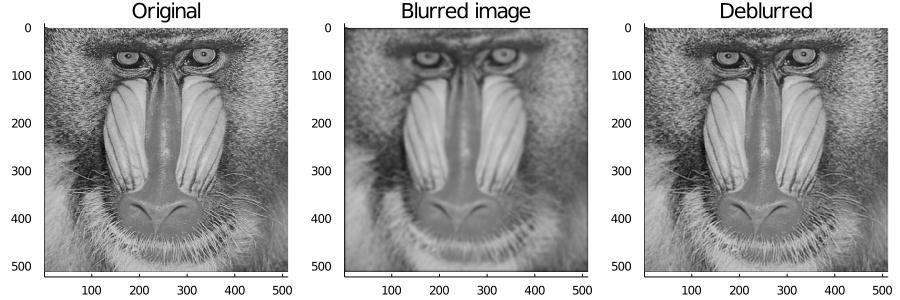

In [106]:
plot(Gray.(X),layout=(1,3),subplot=1,title="Original",aspect_ratio=1,size=(900,300))
plot!(Gray.(Z),subplot=2,title="Blurred image",aspect_ratio=1)
plot!(Gray.(Y),subplot=3,title="Deblurred",aspect_ratio=1)

The reconstruction isn't perfect because the condition number of repeated blurring happens to be very large. 

# Example 8.8.1

Here is a large sparse matrix.

In [107]:
A = 2.8I + sprand(10000,10000,0.002);

Without a preconditioner, GMRES takes a large number of iterations. 

In [108]:
b = rand(10000)
gmres(A,b,maxiter=300,tol=1e-10,restart=50,log=true);
time_plain = @elapsed x,hist1 = gmres(A,b,maxiter=300,tol=1e-10,restart=50,log=true)

0.181368893

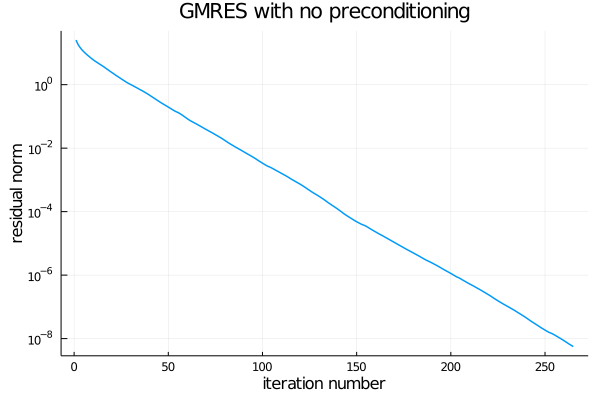

In [109]:
plot(hist1[:resnorm],label="", 
    title="GMRES with no preconditioning",
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )

This version of incomplete $LU$ factorization drops all sufficiently small values (i.e., replaces them with zeros). This keeps the number of nonzeros in the factors under control.

In [110]:
iLU = ilu(A,τ=0.2);
@show nnz(A),nnz(iLU.L);

(nnz(A), nnz(iLU.L)) = (210166, 156552)


It does _not_ produce a true factorization of $A$. However, it's close enough to serve as "approximate inverse" in a preconditioner. 

The actual preconditioning matrix is $\mathbf{M}=\mathbf{L}\mathbf{U}$. However, we just supply the factorization as a left preconditioner, since the preconditioning step is to solve a system with the matrix $\mathbf{M}$.

In [111]:
time_prec = @elapsed x,hist2 = gmres(A,b,Pl=iLU,maxiter=300,tol=1e-10,restart=50,log=true)

7.693507712

The preconditioning is fairly successful in this case.

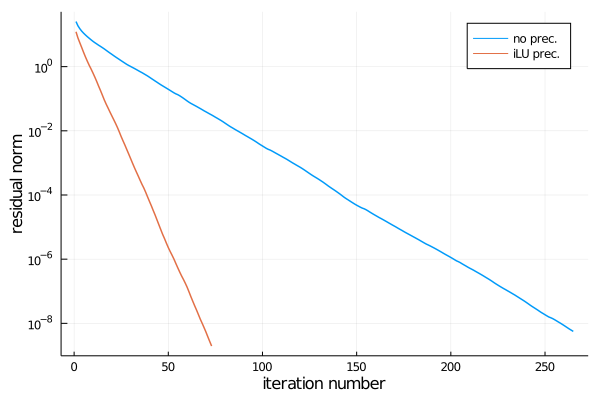

In [112]:
plot(hist1[:resnorm],label="no prec.", 
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )
plot!(hist2[:resnorm],label="iLU prec.")

We probably made each GMRES iteration slower because of the need to apply the preconditioner (here, by solving sparse triangular systems). However, there are a lot fewer iterations needed, and there is a modest gain overall.

# Example 8.8.2

First we create a large, sparse, positive definite matrix that arises in the solution of differntial equations.

In [113]:
n = 100
D2 = spdiagm(0=>fill(2,n-1),1=>-ones(n-2),-1=>-ones(n-2))
IA = spdiagm(0=>ones(n-1))
A = kron(IA,D2) + kron(D2,IA);

Now we solve a linear system with a random right-hand side, without preconditioner.

In [114]:
b = rand(size(A,1))
cg(A,b,maxiter=4,tol=1e-10,log=true);  # make timing more accurate
time_plain = @elapsed x,hist1 = cg(A,b,maxiter=400,tol=1e-10,log=true)

0.032746114

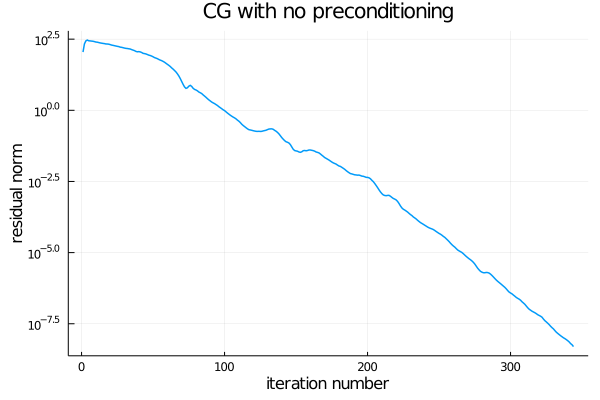

In [115]:
plot(hist1[:resnorm],label="", 
    title="CG with no preconditioning",
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )

For an SPD matrix we can use an incomplete Cholesky factorization. (It uses a lower triangular $\mathbf{L}=\mathbf{R}^T$ rather than an upper triangular $\mathbf{R}$.) 

In [116]:
P = CholeskyPreconditioner(A,1);

Now we apply CG using this preconditioner. 

In [117]:
cg(A,b,Pl=P,maxiter=4,tol=1e-10,log=true);  # make timing more accurate
time_prec = @elapsed x,hist2 = cg(A,b,Pl=P,maxiter=400,tol=1e-10,log=true)

0.19861851

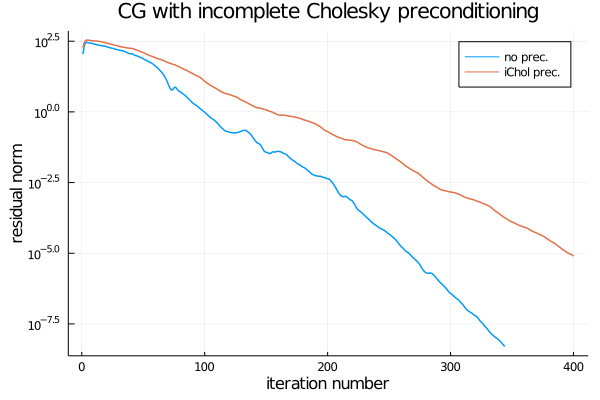

In [118]:
plot(hist1[:resnorm],label="no prec.", 
    xaxis=("iteration number"), yaxis=(:log10,"residual norm"),
    title="CG with incomplete Cholesky preconditioning")
plot!(hist2[:resnorm],label="iChol prec.")

You can see we got a little improvement with this preconditioner. It saved enough iterations to more than make up for the fact that each iteration now involves extra work.